<a href="https://colab.research.google.com/github/glaria/TFM/blob/main/Colab%20Notebooks/5_TFM_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales
Vamos a probar ahora con redes neuronales usando la librería Keras (el uso de GPU's mejora los tiempos de entrenamiento)

Carga del dataset

In [ ]:
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/MyDrive/malware_datasets/balanced_df.csv'

df = pd.read_csv(dataset_path)

Mounted at /content/gdrive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate
from keras.wrappers.scikit_learn import KerasClassifier

def evaluate_model(build_fn, X_train, y_train, X_test, y_test, cv=5):
    metrics = {
        'f1': 'f1',
        'precision': 'precision',
        'accuracy': 'accuracy',
        'recall': 'recall'
    }
    
    #KerasClassifier
    model = KerasClassifier(build_fn=build_fn, epochs=10, batch_size=32, verbose=0)
    
    # Validación cruzada en el conjunto train
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=metrics, return_train_score=True)

    # Entrenamos el modelo
    model.fit(X_train, y_train)

    # Resultados en el conjunto de test
    y_pred = model.predict(X_test)
    test_results = {
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    #modelo entrenado + de los resultados
    return model, cv_results, test_results


In [ ]:
X = df.drop(['Malware', 'data_source'], axis=1) #quitamos columnas no numericas y las etiquetas
y = df['Malware']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

model, cv_results, test_results = evaluate_model(build_model, X_train, y_train, X_test, y_test)


<ipython-input-2-982c83dc8020>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_fn, epochs=10, batch_size=32, verbose=0)


258/258 [==============================] - 0s 2ms/step


Obtenemos los resultados del modelo entrenado

In [ ]:
#resultados de la validación cruzada
print("Resultados de la validación cruzada:")
for metric_name, metric_values in cv_results.items():
    print(f"{metric_name}: {metric_values}")

# resultados en el conjunto de prueba
print("\nResultados en el conjunto de prueba:")
for metric_name, metric_value in test_results.items():
    if metric_name != 'confusion_matrix':
        print(f"{metric_name}: {metric_value}")
    else:
        print(f"{metric_name}:\n{metric_value}")


Resultados de la validación cruzada:
fit_time: [28.16678667 22.07958341 22.63779283 22.55092907 22.58745551]
score_time: [0.60093594 0.49769211 0.96040654 0.52551889 0.50638318]
test_f1: [0.90481283 0.87609912 0.89884918 0.79605432 0.63351526]
train_f1: [0.90963008 0.87983641 0.9009009  0.79283373 0.63208697]
test_precision: [0.91360691 0.93070652 0.89290012 0.69198218 0.9554878 ]
train_precision: [0.91397357 0.93506051 0.89173389 0.69362258 0.96106906]
test_accuracy: [0.90562036 0.88259355 0.89880321 0.75878788 0.72530303]
train_accuracy: [0.90996894 0.88648587 0.89959094 0.75824717 0.72571299]
test_recall: [0.89618644 0.82754455 0.90487805 0.93697226 0.47384336]
train_recall: [0.90532768 0.83077156 0.91025835 0.92516285 0.47089547]

Resultados en el conjunto de prueba:
f1: 0.9137469741368327
precision: 0.9588235294117647
accuracy: 0.9179493394740031
recall: 0.8727184229739596
confusion_matrix:
[[3988  154]
 [ 523 3586]]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_results(model, X_train, y_train, X_test, y_test, model_name):
    print(f"Modelo: {model_name}")

    # Matriz de confusión (mejor visualización)
    y_pred = model.predict(X_test).round()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
    plt.title(f"Matriz de confusión ({model_name})")
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()


Modelo: Modelo de clasificación de malware
258/258 [==============================] - 0s 2ms/step


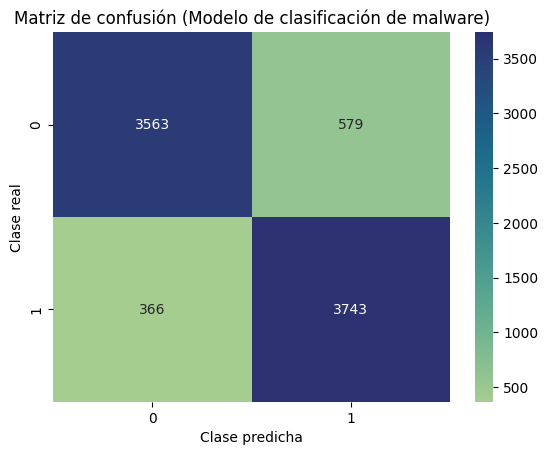

In [ ]:
plot_results(model, X_train, y_train, X_test, y_test, model_name="Modelo de clasificación de malware")


In [ ]:
model = build_model()
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                1920      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 32)                1056      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
None
